In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import numpy as np
import pandas as pd

from rich import print
import os

import scvi
# import nichevi

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import colorcet as cc

# from scib_metrics.benchmark import Benchmarker, BatchCorrection, BioConservation

scvi.settings.seed = 34

# Set SVG font type to 'none' to keep text as text in SVG files
plt.rcParams["svg.fonttype"] = "none"

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Impor

In [3]:
from params import setup

In [4]:
sc.set_figure_params(dpi=150, fontsize=12, format="svg")

figure_dir = setup.FIGURES_FOLDER

plots = True

In [5]:
data_dir, data_file = setup.DATA_FOLDER, setup.DATA_FILE

data_file_name = os.path.splitext(data_file)[0]
print(data_file_name)


path_to_save = os.path.join("../../niche-VI-experiments/checkpoints", data_file_name)
os.makedirs(path_to_save, exist_ok=True)

pancancer_resolvi

# FILTERING PROCESS

In [6]:
# adata = ad.read_h5ad(data_dir + data_file)
adata = ad.read_h5ad(path_to_save + "/pancancer_resolvi_nicheVI_T_Cell.h5ad")

print(adata)

AnnData object with n_obs × n_vars = 444902 × 550
    obs: 'transcript_id', 'x', 'y', 'z', 'observed_x', 'observed_y', 'observed_z', 'fov', 'probability', 
'background', 'confusion', 'patient', 'louvain', 'louvain_final', 'cell_type', 'cell_type_coarse', 'cluster', 
'_indices', '_scvi_batch', '_scvi_ind_x', '_scvi_labels', 'predicted_celltype', 'predicted_celltype_prob', 'index',
'_scvi_sample', 'max_module', 'Module 1', 'Module 2', 'Module 3', 'Module 4', 'Module 5', 'Module 6', 'Module 7', 
'Module 8', 'Module 9', 'Module 10', 'Module 11', 'Module 12', 'organ', 'leiden_T_Cell_0.5', 'leiden_T_Cell_0.3', 
'leiden_T_Cell_0.1', 'leiden_T_Cell_0.2', 'n_counts', 'leiden_T_Cell_1'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden_T_Cell_0.1', 'leiden_T_Cell_0.1_colors', 'leiden_T_Cell_0.2', 
'leiden_T_Cell_0.2_colors', 'leiden_T_Cell_0.3', 'leiden_T_Cell_0.3_colors', 'leiden_T_Cell_0.5', 
'leiden_T_Cell_0.5_colors', 'leiden_T_Cell_1', 'leiden_T_Cell_1_colors', 'neighbors', 'organ_colors', 
'patient_colors', 'predicted_celltype_colors', 'results_s10_scanvi_lr0.0005_poisson_X_nicheVI', 'umap'
    obsm: 'X_resolvi', 'X_scanvi', 'X_spatial', 'X_umap', 'celltype_transfer', 'distance_neighbor', 
'index_neighbor', 'modules_scoress10_scanvi_lr0.0005_poisson_X_nicheVI', 'neighborhood_composition', 
'niche_distances', 'niche_indexes', 'qz1_m_niche_ct', 's10_scanvi_lr0.0005_poisson_X_nicheVI', 'spatial'
    layers: 'counts', 'counts_csc', 'counts_wo_bg', 'estimated_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [7]:
adata.obs[setup.SAMPLE].value_counts()

patient
HumanLungCancerPatient2                 58126
HumanColonCancerPatient2                56459
HumanLiverCancerPatient2                47090
HumanUterineCancerPatient2-RACostain    45432
HumanUterineCancerPatient1              42427
HumanUterineCancerPatient2-ROCostain    37101
HumanLiverCancerPatient1                29609
HumanBreastCancerPatient1               27612
HumanMelanomaPatient1                   20872
HumanMelanomaPatient2                   19626
HumanProstateCancerPatient1             17611
HumanLungCancerPatient1                 16261
HumanProstateCancerPatient2             10151
HumanOvarianCancerPatient1               5246
HumanColonCancerPatient1                 4571
HumanOvarianCancerPatient2Slice1         3059
HumanOvarianCancerPatient2Slice3         2719
HumanOvarianCancerPatient2Slice2          930
Name: count, dtype: int64

In [8]:
adata.obs['T Cell prop'] = adata.obsm['neighborhood_composition']['T Cell']
adata.obs['Cancer Cell prop'] = adata.obsm['neighborhood_composition']['Cancer Cell']
adata.obs["B Cell prop"] = adata.obsm["neighborhood_composition"]["B Cell"]
adata.obs["Macrophage prop"] = adata.obsm["neighborhood_composition"]["Macrophage"]
adata.obs["Suppressive Macrophage prop"] = adata.obsm["neighborhood_composition"]['Suppressive Macrophage']

In [9]:
latent_obsm_key = "s10_scanvi_lr0.0005_poisson_X_nicheVI"

In [10]:
adata.obs["counts_per_cell"] = adata.layers["counts"].sum(axis=1)
adata.obs["counts_per_cell"].min()

9.0

In [11]:
adata.obs['counts_per_cell'] = adata.layers['counts'].sum(axis=1)

adata_filtered_counts = adata[adata.obs.counts_per_cell > 50].copy()

leiden_key = "leiden_T_Cell_0.5"

adata_filtered_counts.obs[leiden_key].value_counts()

leiden_T_Cell_0.5
0     60092
1     54014
2     49579
3     42848
4     42495
5     40197
6     38015
7     36489
8     34874
9     19404
10    11812
11      762
Name: count, dtype: int64

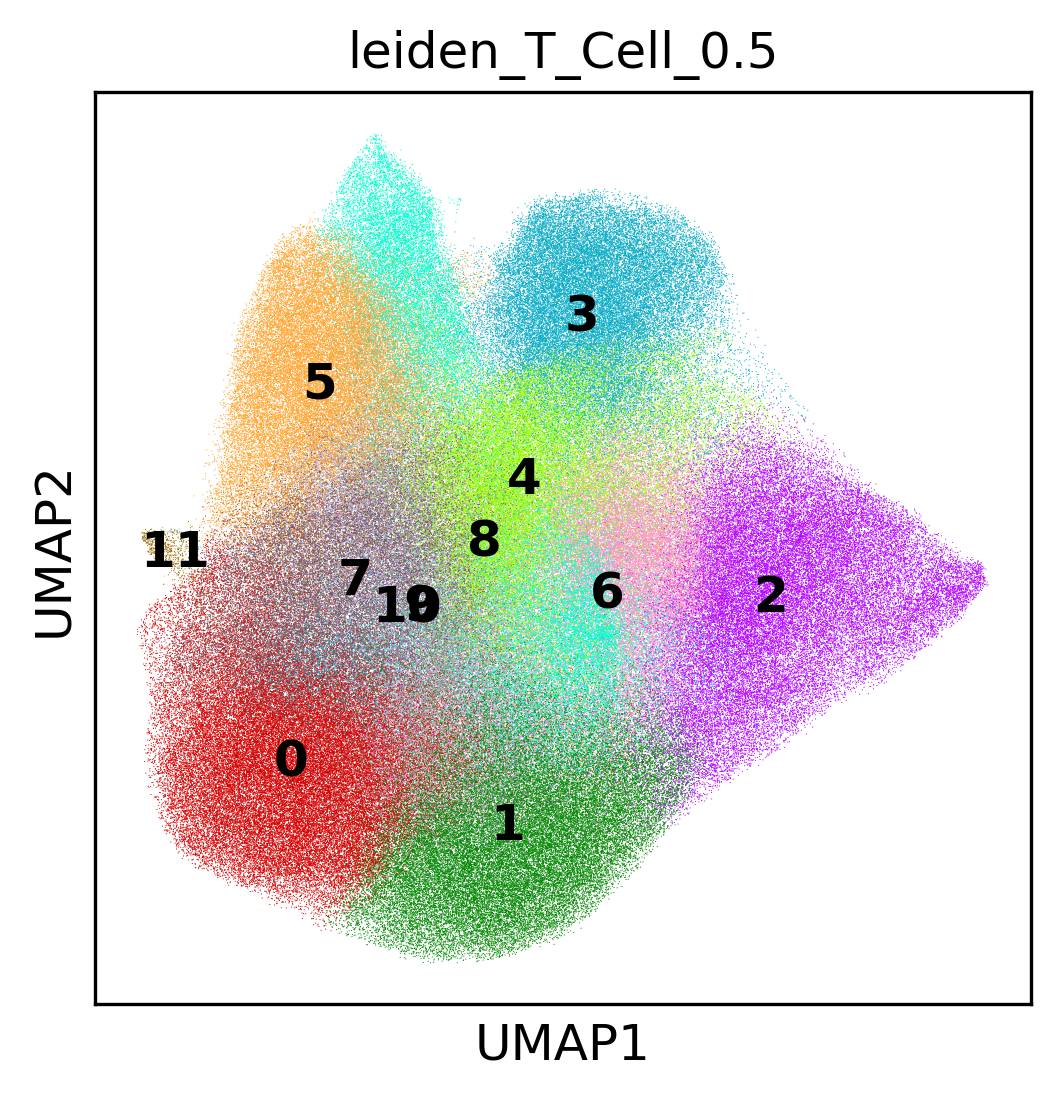

In [12]:
sc.pl.umap(adata_filtered_counts, color=leiden_key, legend_loc="on data", title=leiden_key)

In [13]:
sc.tl.rank_genes_groups(
    adata_filtered_counts,
    groupby=leiden_key,
    method="wilcoxon",
    key_added="rank_genes_T_Cell",
)

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 550 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


{'mainplot_ax': <Axes: >,
 'group_extra_ax': <Axes: >,
 'gene_group_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

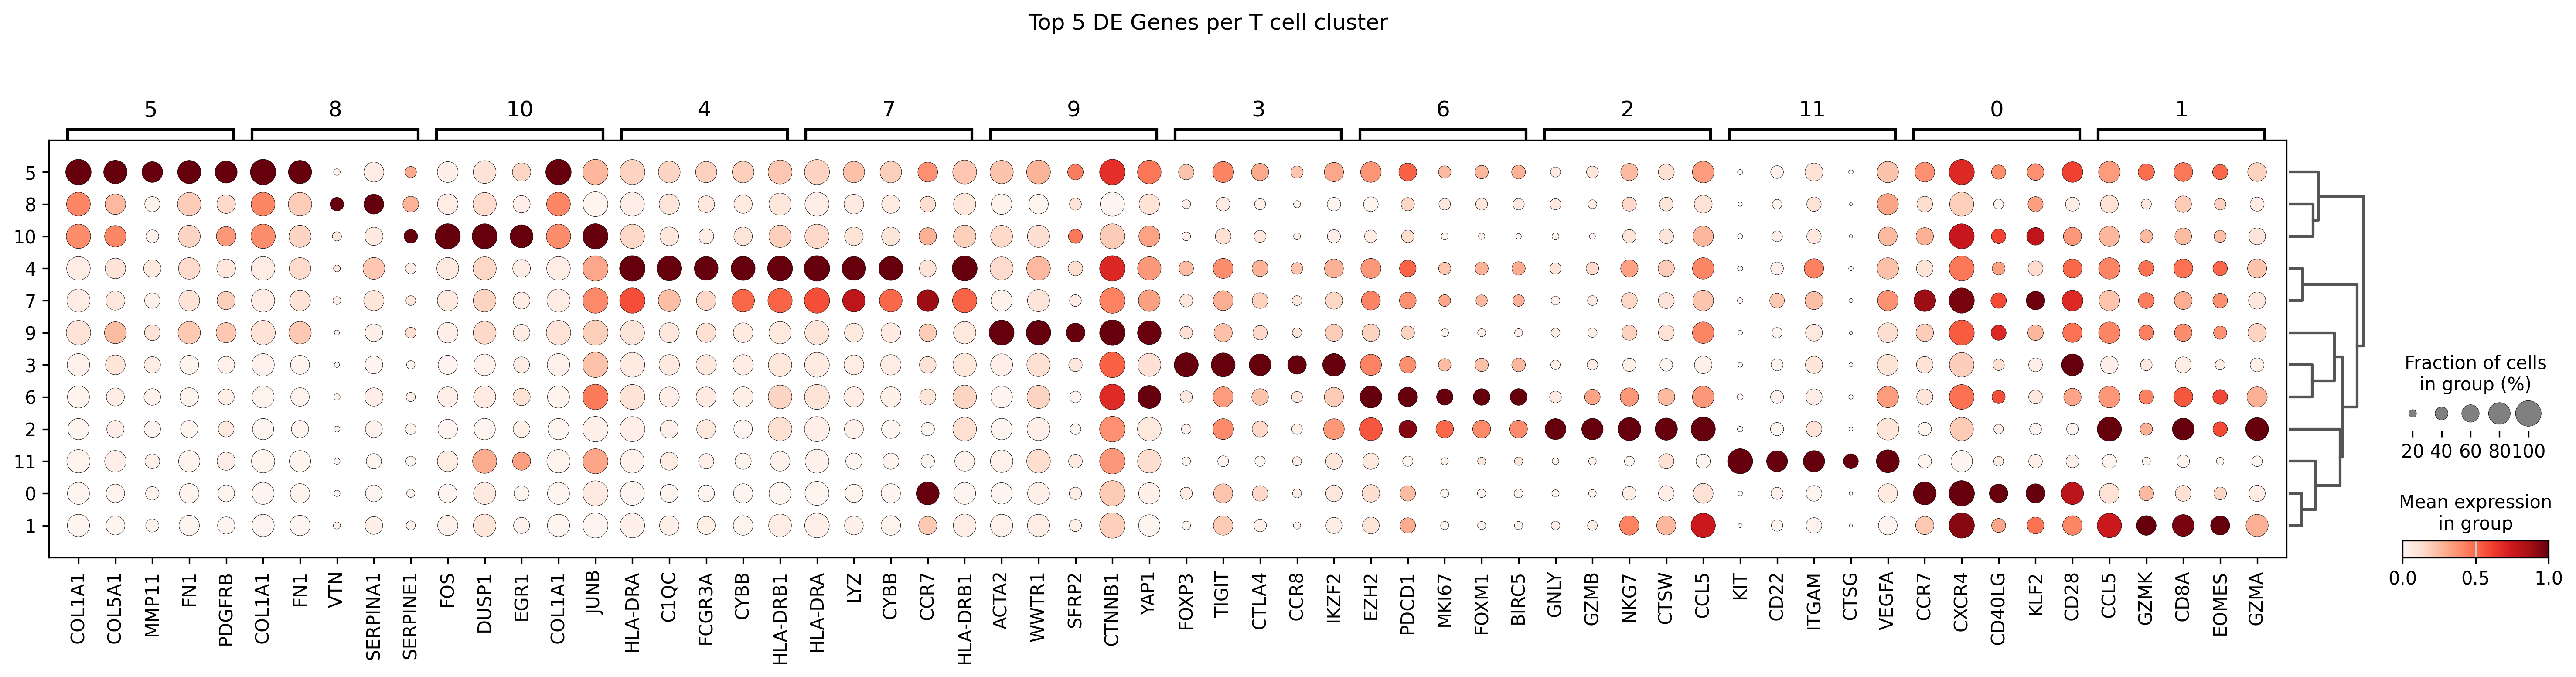

In [14]:
# Extract ranked gene information
n_genes=5
result = adata_filtered_counts.uns["rank_genes_T_Cell"]
groups = result["names"].dtype.names

# Build the dictionary
top_genes = {}
for group in groups:
    top_genes[group] = list(result["names"][group][:n_genes])

# Step 4: Generate a dot plot
sc.pl.dotplot(
    adata_filtered_counts,
    var_names=top_genes,
    groupby=leiden_key,
    standard_scale="var",
    title="Top 5 DE Genes per T cell cluster",
    dendrogram=True,
    show=False,
)
# plt.savefig(f"{figure_dir}/dotplot_leiden_markers.svg", dpi=500)

In [15]:
top_genes

{'0': ['CCR7', 'CXCR4', 'CD40LG', 'KLF2', 'CD28'],
 '1': ['CCL5', 'GZMK', 'CD8A', 'EOMES', 'GZMA'],
 '2': ['GNLY', 'GZMB', 'NKG7', 'CTSW', 'CCL5'],
 '3': ['FOXP3', 'TIGIT', 'CTLA4', 'CCR8', 'IKZF2'],
 '4': ['HLA-DRA', 'C1QC', 'FCGR3A', 'CYBB', 'HLA-DRB1'],
 '5': ['COL1A1', 'COL5A1', 'MMP11', 'FN1', 'PDGFRB'],
 '6': ['EZH2', 'PDCD1', 'MKI67', 'FOXM1', 'BIRC5'],
 '7': ['HLA-DRA', 'LYZ', 'CYBB', 'CCR7', 'HLA-DRB1'],
 '8': ['COL1A1', 'FN1', 'VTN', 'SERPINA1', 'SERPINE1'],
 '9': ['ACTA2', 'WWTR1', 'SFRP2', 'CTNNB1', 'YAP1'],
 '10': ['FOS', 'DUSP1', 'EGR1', 'COL1A1', 'JUNB'],
 '11': ['KIT', 'CD22', 'ITGAM', 'CTSG', 'VEGFA']}

Hi, I have these T cells subclusters, each one is characterized by 10 top genes. can you tell me what are these subclusters based on the markers? Also, can you find outlier clusters, i.e. non T cells? 


In [16]:
sc.get.rank_genes_groups_df(adata_filtered_counts, group='6', key="rank_genes_T_Cell").head(15)

,names,scores,logfoldchanges,pvals,pvals_adj
0,EZH2,86.148552,2.060430,0.0,0.0
1,PDCD1,84.459335,1.908385,0.0,0.0
2,MKI67,83.787254,3.397593,0.0,0.0
3,FOXM1,83.529160,2.537774,0.0,0.0
4,BIRC5,83.521034,2.533895,0.0,0.0
5,MYBL2,80.071953,2.301633,0.0,0.0
6,PCNA,75.758247,2.121370,0.0,0.0
7,PLK1,74.403107,2.676885,0.0,0.0
8,MCM2,72.981659,2.330824,0.0,0.0
9,JUN,71.144089,2.848850,0.0,0.0


In [17]:
adata_filtered_outliers = (
    adata_filtered_counts[adata_filtered_counts.obs[leiden_key]
    .isin(["0", "1", "2", "3", "6"])]
    .copy()
)
adata_filtered_outliers

AnnData object with n_obs × n_vars = 244548 × 550
    obs: 'transcript_id', 'x', 'y', 'z', 'observed_x', 'observed_y', 'observed_z', 'fov', 'probability', 'background', 'confusion', 'patient', 'louvain', 'louvain_final', 'cell_type', 'cell_type_coarse', 'cluster', '_indices', '_scvi_batch', '_scvi_ind_x', '_scvi_labels', 'predicted_celltype', 'predicted_celltype_prob', 'index', '_scvi_sample', 'max_module', 'Module 1', 'Module 2', 'Module 3', 'Module 4', 'Module 5', 'Module 6', 'Module 7', 'Module 8', 'Module 9', 'Module 10', 'Module 11', 'Module 12', 'organ', 'leiden_T_Cell_0.5', 'leiden_T_Cell_0.3', 'leiden_T_Cell_0.1', 'leiden_T_Cell_0.2', 'n_counts', 'leiden_T_Cell_1', 'T Cell prop', 'Cancer Cell prop', 'B Cell prop', 'Macrophage prop', 'Suppressive Macrophage prop', 'counts_per_cell'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden_T_Cell_0.1', 'leiden_T_Cell_0.1_colors', 'leiden_T_Cell_0.2', 'leiden_T_Cell_0.2_colors', 'leiden_T_Cell_0.3', 'leiden_T_Cell_0.